## Import Necessary packages

In [1]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import plotly.express as px; import plotly.graph_objects as go
import os, openpyxl; import ipywidgets as widgets; import xlwings as xw

from ipywidgets import Checkbox, Dropdown, Layout
from IPython.display import Image, display
from plotly.subplots import make_subplots

try:
    from ipyfilechooser import FileChooser
except ModuleNotFoundError:
    print("Installing ipyfilechooser...")
    %pip install ipyfilechooser -q
    
#Last updated - August 16th, 2024 - Ritvik

### Folder & Directory Selection

In [2]:
# Pick where files are stored locally
fc = FileChooser(
    "..",
    title="<b>Select RESOLVE results folder:</b>",
    layout=Layout(width="800px"),
    show_only_dirs=True,
)
fc._show_dialog()
display(fc)

# Select the appropriate Results Viewer
rv = FileChooser(
    "..",
    title="<b>Select Results Viewer:</b>",
    layout=Layout(width="800px"),
    filter_pattern="[!~$]*.xls*",
)
rv._show_dialog()
display(rv)

FileChooser(path='C:\Users\ritvik.jain\PycharmProjects2', filename='', title='<b>Select RESOLVE results folder…

FileChooser(path='C:\Users\ritvik.jain\PycharmProjects2', filename='', title='<b>Select Results Viewer:</b>', …

#### Master Inputs (Run the block below anytime you change folders, and other inputs)

#### Dispatch Day Selection

Using the Sample Day Description below to select what particular day or condition you would like to look at


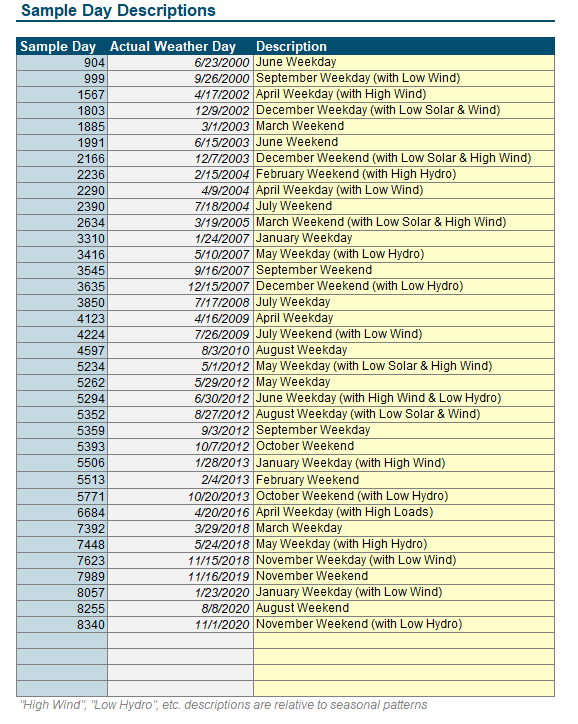

In [3]:
display(Image(filename='dispatch-day-description.png', width=400))

In [12]:
rv_path = rv.selected ; case_path = fc.selected
rep_period_options = [904, 999, 1567, 1803, 1885, 1991, 2166, 2236, 2290, 2390, 2634, 3310,
                    3416, 3545, 3635, 3850, 4123, 4224, 4597, 5234, 5262, 5294, 5352, 5359,
                    5393, 5506, 5513, 5771, 6684, 7392, 7448, 7623, 7989, 8057, 8255, 8340]

rep_periods = [999]

zone = "CAISO"

model_year = 2045
# Please make sure that the model_year selected was present in your final RESOLVE run

### Helper variables & Resource Groupings  

In [5]:
color_discrete_map = {
    "Biomass": "#008A37","Biogas":"#92D050","CHP": "#4C0000",
    "Geothermal": "#AF2200", "Hydro": "#034E6E", "Pumped Hydro Storage": "#B381D9",
    "Li-ion Battery (4-hr)": "#7030A0", "Li-ion Battery (8-hr)": "#8E9BE3", "Offshore Wind": "#B0E6FD",
    "Out-of-State Wind": "#66FFFF", "In-State Wind":"#15B5F9", "Wind":"#15B5F9",
    "Customer Solar": "#FFDE86", "Solar": "#FFAF00", "Natural Gas with CCS": "#765400",
    "Natural Gas": "#6E6E6E", "Nuclear": "#C4BD97", "Hydrogen":"#005400", "Enhanced Geothermal":"#FF0000",
    "Imports": "#FFC9BB",  "Long Duration Storage":"#FF9F88",  "Coal" : "#000000",
    "Shed DR": "#FF66FF"
    
}
resource_order = ["Nuclear", "Natural Gas", "CHP", "Biogas","Biomass","Geothermal","Hydro",
                  "In-State Wind","Wind","Out-of-State Wind","Offshore Wind","Solar","Customer Solar",
                 "Li-ion Battery (4-hr)","Li-ion Battery (8-hr)", "Long Duration Storage","Pumped Hydro Storage",
                 "imports"]

def get_groupings_from_rv(rv_path = rv_path):
    
    rv = xw.Book(rv_path)
    a = rv.sheets['Results Grouping'].range('component_results_groups').value
    df = pd.DataFrame(a[1:], columns=a[0])
    df = df[df['Result Type']=='Resource Type']
    df = df.copy()
    df.rename(columns={'Component':'Resource'},inplace =True)
    df.drop(columns='Result Type',inplace=True)
    
    rv.close()
    
    return df 
grouped_df = get_groupings_from_rv()
print ("Resource Groupings for Plotting Retrieved from Results Viewer")

Resource Groupings for Plotting Retrieved from Results Viewer


### Data manipulation Functions

In [6]:
def get_resource_dispatch_summary(case_path):
    
    filepath = os.path.join(case_path, "results_summary", "resource_dispatch_summary.csv")
    resource_dispatch_summary = pd.read_csv(filepath)

    # convert Model_Year to datetime
    resource_dispatch_summary["Model Year"] = pd.to_datetime(resource_dispatch_summary["Model Year"]).apply(
        lambda x: x.year )
    
    return resource_dispatch_summary

def get_power_provided_df(resource_dispatch_summary, rep_periods):
    if not isinstance(rep_periods, list):
        rep_periods = [rep_periods]
    power_provided_df = resource_dispatch_summary.loc[
        resource_dispatch_summary.Rep_Period.isin(rep_periods),
        ["Model Year", "Rep_Period", "Hour", "Zone", "Resource", "Provide Power (MW)"],
    ]

    day = 0
    for rep_period in rep_periods:
        power_provided_df.loc[power_provided_df.Rep_Period == rep_period, "DAY"] = day
        day += 1
    power_provided_df["Hour"] = power_provided_df["Hour"] + (power_provided_df["DAY"] * 24)
    power_provided_df["Hour"] = power_provided_df["Hour"].apply(lambda x: int(x))

    return power_provided_df

def get_load_increased_df(resource_dispatch_summary, rep_periods):
    if not isinstance(rep_periods, list):
        rep_periods = [rep_periods]
    load_increased_df = resource_dispatch_summary.loc[
        resource_dispatch_summary.Rep_Period.isin(rep_periods),
        ["Model Year", "Rep_Period", "Hour", "Zone", "Resource", "Increase Load (MW)"],
    ]

    day = 0
    for rep_period in rep_periods:
        load_increased_df.loc[load_increased_df.Rep_Period == rep_period, "DAY"] = day
        day += 1
    load_increased_df["Hour"] = load_increased_df["Hour"] + (load_increased_df["DAY"] * 24)
    load_increased_df["Hour"] = load_increased_df["Hour"].apply(lambda x: int(x))

    return load_increased_df

def get_summary_loads(casepath,rep_periods):
    
    load_path = os.path.join(case_path, "parameters","input_load_mw.csv")
    load_df = pd.read_csv(load_path)
    
    nl = pd.DataFrame()
    
    for zone in load_df.ZONES.unique():
        nl[zone] = load_df[load_df['ZONES']==zone]['input_load_mw'].values
    
    nl['REP_PERIODS'] = load_df[load_df['ZONES']==zone]['REP_PERIODS'].values
    nl['HOURS'] = load_df[load_df['ZONES']==zone]['HOURS'].values
    nl['MODEL_YEARS'] = load_df[load_df['ZONES']==zone]['MODEL_YEARS'].values
    
    if not isinstance(rep_periods, list):
        rep_periods = [rep_periods]
    nl = nl.loc[nl.REP_PERIODS.isin(rep_periods)]
    
    return nl

def get_hourly_transmission_results_df(case_path, rep_periods):

    hourly_transmission_results_filepath = os.path.join(case_path, "variables","Transmit_Power_MW.csv")
    hourly_transmission_results_df = pd.read_csv(hourly_transmission_results_filepath)
    transmission_summary_filepath = os.path.join(case_path,"results_summary","transmission_summary.csv")
    transmission_summary_df = pd.read_csv(transmission_summary_filepath)
    transmission_summary_df = transmission_summary_df[["Transmission Path", "Zone From", "Zone To"]]
    transmission_summary_df.rename(
        columns={"Transmission Path": "TRANSMISSION_LINES", "Zone From": "Zone_From", "Zone To": "Zone_To"},
        inplace=True)

    # join dfs
    hourly_transmission_results_df = hourly_transmission_results_df.merge(
        transmission_summary_df, how="left", on="TRANSMISSION_LINES")

    # filter on rep_periods
    if not isinstance(rep_periods, list):
        rep_periods = [rep_periods]
    hourly_transmission_results_df = hourly_transmission_results_df.loc[
        hourly_transmission_results_df.REP_PERIODS.isin(rep_periods) ]

    # change hours to hours in list of rep_periods provided
    day = 0
    for rep_period in rep_periods:
        hourly_transmission_results_df.loc[hourly_transmission_results_df.REP_PERIODS == rep_period, "DAY"] = day
        day += 1
    hourly_transmission_results_df["HOURS"] = hourly_transmission_results_df["HOURS"] + (
        hourly_transmission_results_df["DAY"] * 24 )
    hourly_transmission_results_df["HOURS"] = hourly_transmission_results_df["HOURS"].apply(lambda x: int(x))
    
    return hourly_transmission_results_df

def add_imports_to_power_provided_df(power_provided_df, hourly_transmission_results_df):
    # group transmission results by Zone_To
    zonal_hourly_imports_to = hourly_transmission_results_df.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone_To"], as_index=False
    ).sum(numeric_only=True)
    # remove negative numbers (exports) from imports df
    zonal_hourly_imports_to.loc[zonal_hourly_imports_to["Transmit_Power_MW"] < 0, "Transmit_Power_MW"] = 0
    zonal_hourly_imports_to.rename(columns={"Zone_To": "Zone"}, inplace=True)

    # add negative values to imports for "Zone_From" zone
    zonal_hourly_imports_from = hourly_transmission_results_df.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone_From"], as_index=False
    ).sum(numeric_only=True)
    # remove positive numbers (exports) from imports df
    zonal_hourly_imports_from.loc[zonal_hourly_imports_from["Transmit_Power_MW"] > 0, "Transmit_Power_MW"] = 0
    zonal_hourly_imports_from["Transmit_Power_MW"] = -zonal_hourly_imports_from["Transmit_Power_MW"]
    zonal_hourly_imports_from.rename(columns={"Zone_From": "Zone"}, inplace=True)

    # combine two dfs into zonal_hourly_imports
    zonal_hourly_imports = pd.concat([zonal_hourly_imports_to, zonal_hourly_imports_from])
    zonal_hourly_imports = zonal_hourly_imports.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone"], as_index=False
    ).sum(numeric_only=True)

    # # change names of hourly imports columns
    zonal_hourly_imports.rename(
        columns={
            "MODEL_YEARS": "Model Year",
            "REP_PERIODS": "Rep_Period",
            "HOURS": "Hour",
            "Transmit_Power_MW": "Provide Power (MW)",
        },
        inplace=True,
    )

    # # Add column for Resource name
    zonal_hourly_imports["Resource"] = "Imports"

    # # concat two dfs
    power_provided_and_imported = pd.concat([power_provided_df, zonal_hourly_imports], keys=["Generation", "Imports"])

    return power_provided_and_imported

def sum_zonal_hourly_exports(hourly_transmission_results_df):
    # group transmission results by zone_from
    zonal_hourly_exports_from = hourly_transmission_results_df.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone_From"], as_index=False
    ).sum(numeric_only=True)
    # remove negative numbers (imports) from exports df
    zonal_hourly_exports_from.loc[zonal_hourly_exports_from["Transmit_Power_MW"] < 0, "Transmit_Power_MW"] = 0
    zonal_hourly_exports_from.rename(columns={"Zone_From": "Zone"}, inplace=True)

    # group transmission results by zone_to
    zonal_hourly_exports_to = hourly_transmission_results_df.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone_To"], as_index=False
    ).sum(numeric_only=True)
    # remove positive numbers (imports) from exports df
    zonal_hourly_exports_to.loc[zonal_hourly_exports_to["Transmit_Power_MW"] > 0, "Transmit_Power_MW"] = 0
    zonal_hourly_exports_to["Transmit_Power_MW"] = -zonal_hourly_exports_to["Transmit_Power_MW"]
    zonal_hourly_exports_to.rename(columns={"Zone_To": "Zone"}, inplace=True)

    # concat zonal_hourly_exports
    zonal_hourly_exports = pd.concat([zonal_hourly_exports_from, zonal_hourly_exports_to])
    zonal_hourly_exports = zonal_hourly_exports.groupby(
        by=["MODEL_YEARS", "REP_PERIODS", "HOURS", "Zone"], as_index=False
    ).sum(numeric_only=True)

    # change name of Transmit_Power_MW
    zonal_hourly_exports.rename(columns={"Transmit_Power_MW": "Exports (MW)"}, inplace=True)

    return zonal_hourly_exports

In [7]:
# TODO: sum up loads by specifying/sorting hour

def create_dispatch_plot(
    power_provided_df, load_summary_df, load_increased_df, zonal_hourly_exports=None, model_year=model_year, zone=zone):
    
    power_provided_df = (power_provided_df.loc[power_provided_df["Model Year"] == model_year])
    load_summary_df = (load_summary_df.loc[load_summary_df["MODEL_YEARS"] == model_year])
    load_increased_df = (load_increased_df.loc[load_increased_df["Model Year"] == model_year]) 
    zonal_hourly_exports = (zonal_hourly_exports.loc[zonal_hourly_exports["MODEL_YEARS"] == model_year])
    
    #Convert from Mwh -> Gwh
    power_provided_df = power_provided_df.copy() ; load_increased_df = load_increased_df.copy()
    load_summary_df = load_summary_df.copy(); zonal_hourly_exports = zonal_hourly_exports.copy()  
    power_provided_df['Provide Power (MW)'] /= 1000 ;load_increased_df['Increase Load (MW)'] /= 1000
    load_summary_df[zone] /= 1000 ; zonal_hourly_exports.loc[zonal_hourly_exports["Zone"] == zone, "Exports (MW)"] /= 1000
    
    exclude_groups = ["Baseline PHS", "Gas Capacity Not Retained", "Baseline DR","Coal", "Li-ion Battery", "Shed DR"]

    #Filter out the specified groups from the DataFrame
    power_provided_df = power_provided_df.loc[(power_provided_df.Zone == zone) & 
                                              (~power_provided_df["Resource"].isin(exclude_groups))]
    
    # plot generation
    if zone == "all_zones":
        # if looking at all zones, ignore imports
        fig = px.area(power_provided_df, x="Hour", y="Provide Power (MW)", color="Resource",
                      color_discrete_map=color_discrete_map)

        # sum charging load by hour
        charging_load = (
            load_increased_df[["Hour", "Increase Load (MW)"]]
            .fillna(0)
            .groupby(by=["Hour"])
            .sum(numeric_only=True)["Increase Load (MW)"]
        )
    else:
        fig = px.area(
            power_provided_df.loc[power_provided_df.Zone == zone], x="Hour", y="Provide Power (MW)", color="Resource",
            color_discrete_map=color_discrete_map,category_orders={"Resource": resource_order}
        )

        # sum charging load by zone and by hour
        load_increased_df = load_increased_df.loc[load_increased_df.Zone == zone]
        charging_load = (
            load_increased_df[["Hour", "Increase Load (MW)"]]
            .fillna(0)
            .groupby(by=["Hour"])
            .sum(numeric_only=True)["Increase Load (MW)"]
        )

    # plot load without battery charging
    fig2 = px.line(load_summary_df, x="HOURS", y=zone)

    # plot load with battery charging
    load_summary_copy = load_summary_df.copy()
    load_summary_copy["Load Including Charging"] = load_summary_df[zone] + charging_load.values
    fig3 = px.line(load_summary_copy, x="HOURS", y="Load Including Charging")

    # plot load with exports
    if zone != "all_zones":
        load_summary_copy["Load Including Charging and Exports"] = (
            load_summary_copy["Load Including Charging"]
            + zonal_hourly_exports.loc[zonal_hourly_exports["Zone"] == zone, "Exports (MW)"].values
        )
        fig4 = px.line(load_summary_copy, x="HOURS", y="Load Including Charging and Exports")

    # add all plots to subfig
    subfig = make_subplots()
    fig2.update_traces(showlegend=True, name="Load",line_color="black")
    fig3.update_traces(showlegend=True, name="Load with charging", line_color="black", patch={"line": {"dash": "dash"}})
    if zone == "all_zones":
        subfig.add_traces(fig.data + fig2.data + fig3.data)
    else:
        fig4.update_traces(
            showlegend=True, name="Load with charging and exports", line_color="black",  patch=dict(line=dict(dash="dot")))
        subfig.add_traces(fig.data + fig2.data + fig3.data + fig4.data)

    for trace in subfig.data:
        if trace.name not in ["Load", "Load with charging", "Load with charging and exports"]:
            trace.update(line=dict(width=0))  # Remove boundary line
            trace.update(fillcolor=color_discrete_map[trace.name])
    
    subfig.update_layout(
        title={
        'text': "{} Zone Dispatch in {}".format(zone,model_year),
        'font': dict(family='Arial', size=16, color='black')  # Customize font size and color
        },
        xaxis  = dict(showgrid=False, title="Hour of Day (Starting)", tickmode="linear",
                       tick0=0, dtick=2, ticks="outside", tickwidth=1, ticklen=5,
                       tickfont=dict(family='Arial',size=14,color='black'),
                     ),
        yaxis  = dict(showgrid=False,title="Energy Dispatch in GWh",
                     ticks="outside", tickwidth=1, ticklen=5,
                     tickfont=dict(family='Arial',size=14,color='black'),
                    ),
        
        plot_bgcolor='white',paper_bgcolor='white',
        shapes= [ dict(type='line', x0=0, x1=0, y0=0, y1=1, xref='x', yref='paper',
                     line=dict(color='black',width=0.5)) ]
                        )

    subfig.show(color_discrete_map=color_discrete_map)

In [8]:
def dispatch_plot_from_raw_results(case_path, rep_periods, model_year=model_year, zone=zone):

    resource_dispatch_summary = get_resource_dispatch_summary(case_path)
    power_provided_df = get_power_provided_df(resource_dispatch_summary, rep_periods)
    load_increased_df = get_load_increased_df(resource_dispatch_summary, rep_periods)
    load_summary_df = get_summary_loads(case_path,rep_periods)

    if zone == "all_zones":
        create_dispatch_plot(power_provided_df, load_summary_df, load_increased_df)
    else:
        hourly_transmission_results_df = get_hourly_transmission_results_df(case_path, rep_periods)
        hourly_transmission_results_df.drop_duplicates(inplace=True)
        power_provided_df = add_imports_to_power_provided_df(power_provided_df, hourly_transmission_results_df)
        zonal_hourly_exports = sum_zonal_hourly_exports(hourly_transmission_results_df)
        merged_df = pd.merge(power_provided_df, grouped_df, on='Resource')
        grouped_sum_df = merged_df.groupby(['Model Year','Rep_Period',
                                    'Hour','Zone','DAY','Group Name']).agg({'Provide Power (MW)': 'sum'}).reset_index()
        power_provided_df_grouped = add_imports_to_power_provided_df(grouped_sum_df,hourly_transmission_results_df)
        power_provided_df_grouped['Group Name'] = power_provided_df_grouped['Group Name'].fillna('Imports')
        power_provided_df_grouped.rename(columns={'Group Name':'Resource'},inplace=True)
        power_provided_df_grouped = power_provided_df_grouped.iloc[:,:-1]

        create_dispatch_plot(power_provided_df_grouped, load_summary_df, 
                             load_increased_df, zonal_hourly_exports, zone=zone)

In [11]:
#Define zone here as well please
dispatch_plot_from_raw_results(case_path, rep_periods, zone=zone)

C:\Users\ritvik.jain\AppData\Local\anaconda3\lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



<div class="alert alert-block alert-info">
    ℹ️ <b>You can also save the dispatch plot directly back to RV (Optional)</b><br><br>
    If you'd like a specific dispatch plot saved so you dont have to run the script again
    then, just run the code block below </b>.
</div>

In [15]:
# To-do -> Add flexible functionality to add dispatch plot back to the selected RV